In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
%matplotlib inline
path = '.\\BaselineImages'
list_image_files = os.listdir(path)

# 1. Introduction
On the Moonboard website there are a set of "baseline" problems, believed to be set and reviewed, so that they are the correct grade. These problems could be more consistent and better modelled through a regression algorithm, as they will have been reviewed by experts.

# 2. Conversion to V-Grades

In [ ]:
# get original scraped data from web
data=pd.read_excel('BaselineProblems.xlsm',sheetname='Data')
# get conversion from font to v-grade scale
conversion=pd.read_excel('Moon2017_40degrees_test.xlsx',sheetname='Conversion')
# Add V-grades to the dataframe
m,n = data.shape
v_grades = np.array([int(conversion[conversion['Font_Grade']==x]['V_Grade']) for x in data['Grade']])
data['V_Grades'] = v_grades

# 3. Identify number of Holds
- Scraped data is formatted and saved into new excel workbook.
- Amount of holds is identified of each type for each image

In [4]:
def hold_identify(path,image_name):
    """Function takes in path and image name and returns red,green,blue holds
    Parameters
    ----------
    path : string
        path of image file
    image_name : string
        image file name
    Returns
    ----------
    [red,green,blue] : list of ints
        red holds, green holds, blue holds
    """
    imag = Image.open("{0}\\{1}".format(path,image_name))
    image_array = np.array(imag.getdata())
    red = image_array[(image_array[:,0]==255)&(image_array[:,1]==0)&(image_array[:,2]==0)&(image_array[:,3]==255),:].shape
    red = red[0]
    red = int(red/1050)
    green = image_array[(image_array[:,0]==0)&(image_array[:,1]==255)&(image_array[:,2]==0)&(image_array[:,3]==255),:].shape
    green = green[0]
    green = int(green/1050)
    blue = image_array[(image_array[:,0]==0)&(image_array[:,1]==0)&(image_array[:,2]==255)&(image_array[:,3]==255),:].shape
    blue = blue[0]
    blue = int(blue/1050)
    #print(list_image_files[i])
    #print('Red: {0},Green: {1},Blue: {2}'.format(red,green,blue))
    return [red,green,blue]

In [13]:
# create an array of all the rgb holds
rgb_array=[]
for image in data['FileName']:
    imag = '{0}'.format(image)
    rgb_array.append(hold_identify(path,imag))
rgb_array=np.array(rgb_array)
print('run')
# Add hold information to the dataframe
data['red']=rgb_array[:,0]
data['green']=rgb_array[:,1]
data['blue']=rgb_array[:,2]
data.head()
# save to excel
data.to_excel('BaselineProblems.xlsm')

run


# 4. Initial Data Summary
- reload formatted data
- histogram & boxplot of data

In [157]:
data = pd.read_excel('BaselineProblems.xlsm')

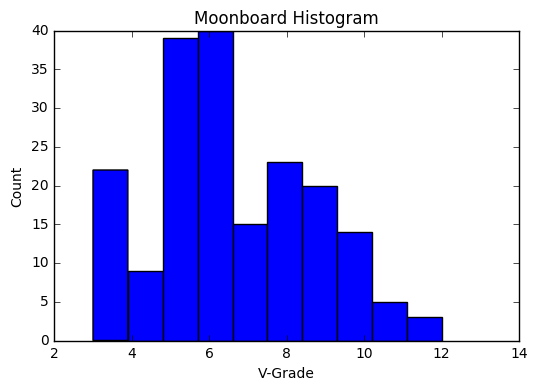

In [63]:
plt.hist(data['V_Grades'],bins=10)
plt.title('Moonboard Histogram')
plt.xlabel('V-Grade')
plt.ylabel('Count')
plt.show()

# 5. Additional Features Identification
- Find key statistics for the problem (min distance, max distance, mean distance, median distance, range of distances, min & max angle between holds, mean angle)

# 5.1 Data extraction function
- Constructing an algorithm to extract key info

In [5]:
def get_image_data(path,image_name,hold_number):
    """
    Parameters
    -----------
    path : folder of file location
    image_name : file name image
    Returns
    -----------
    stat_arr : array of statistical data in the format:
    max_distance,mean_distance,std_distance,mean_angle"""
    # step 1 load image
    image_open = Image.open("{0}\\{1}".format(path,image_name))
    image_data = np.array(image_open.getdata())
    # create relevant dictionaries for colours
    rgb_dic = {'red' : [255,0,0,255],'green' : [0,255,0,255],'blue' : [0,0,255,255]}
    # step 2 create binary array of image
    image_binary = np.zeros(len(image_data))
    for key in rgb_dic.keys():
        image_binary[(image_data[:,0]==rgb_dic[key][0])&(image_data[:,1]==rgb_dic[key][1])&(image_data[:,2]==rgb_dic[key][2]) & (image_data[:,3]==rgb_dic[key][3])]=1
    image_binary  = image_binary.reshape(image_open.height,image_open.width)
    # step 3 locate centre of each cluster
    # fit the pixel locations to a KMeans clustering model to find centre points
    y,x=np.where(image_binary==1)
    m=x.size
    x=x.reshape(m,1)
    y=y.reshape(m,1)
    YX=np.concatenate((y,x),axis=1)
    hold_kmeans=KMeans(n_clusters=hold_number)
    hold_kmeans.fit(YX)
    hold_ctr = hold_kmeans.cluster_centers_
    # invert the height
    hold_ctr[:,0]=1000-hold_ctr[:,0]
    # sort by height
    hold_ctr = hold_ctr[hold_ctr[:,0].argsort()]
    # step 4 find distances and angles between each consecutive cluster (hold)
    height,width = hold_ctr.shape
    distance_l = []
    angle_l = []
    for h in range(height-1):
        first = hold_ctr[h,:]
        second = hold_ctr[h+1,:]
        fs=np.abs(second-first)
        o=fs[0]
        a=fs[1]
        distance = np.sqrt(o**2+a**2)
        angle = np.degrees(np.arctan(o/a))
        distance_l.append(distance)
        angle_l.append(angle)
    # step 5 output statistics
    #max_distance,mean_distance,std_distance,mean_angle
    stat_arr = np.array([[np.max(distance_l),np.mean(distance_l),np.std(distance_l),np.mean(angle_l)]])
    return stat_arr

# 5.3 Data Extraction run

In [18]:
data['total_holds']=np.sum(data[['red','green','blue']],axis=1)
# set index of data so that can easily select and join with other data later
data=data.set_index('FileName')

In [20]:
# Loop through all entries from data  and apply algorithm to find max/mean/std data
first = True
for name in data.index:
    hold_number = int(data[data.index==name]['total_holds'])
    result = get_image_data(path,name,hold_number)
    result = np.concatenate((np.array([[name]]),result),axis=1)
    if first == True:
        result_arr = result
        first = False
    else:
        result_arr = np.concatenate((result_arr,result),axis=0)
print('Result array constructed')

C:\Users\Frank\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: divide by zero encountered in double_scalars


Result array constructed


In [ ]:
result_df = pd.DataFrame(result_arr,columns=['Image_Name','Max_dist','Mean_dist','Std_dist','Mean_angle'])
# set the indexes to match
result_df=result_df.set_index(data.index)
# drop the now unused Image_Name column from our data frame
result_df = result_df.drop('Image_Name',axis=1)
# concatenate the two dataframes together
data=pd.concat((data,result_df),axis=1)
# save the data to excel
data.to_excel('BaselineProblems.xlsm')

# 6. Logistic Regression
- Can a logistic regression be used to suitably predict grades based on the data?

# 6.1 Training

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
logistic_regression = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(training_df, training_grade_df, test_size=0.33, random_state=42)
logistic_regression.fit(X_train,y_train)
prediction = logistic_regression.predict(X_test)

# 6.2 Results
Accuracy score of only 28.5%.This is lower than our first training set. There are less Baseline problems, which could result in less information to train the model on. However, if the problems were more accurate generally we would expect to see a marked increase in accuracy of the model. The fundamental problem of climbing grades appears to be their subjectivity.

In [33]:
accuracy_score(y_test,prediction)

0.2857142857142857

# 6.3 Next Steps
- What features actually help with prediction?
- What if climbing grades are non-linear?

In [122]:
# criteria we could use for model
criteria_list = list(data.columns[5:])

['0: red', '1: green', '2: blue', '3: total_holds', '4: Max_dist', '5: Mean_dist', '6: Std_dist', '7: Mean_angle', '8: hold_type_0', '9: hold_type_1', '10: hold_type_2', '11: hold_type_3', '12: hold_type_4']


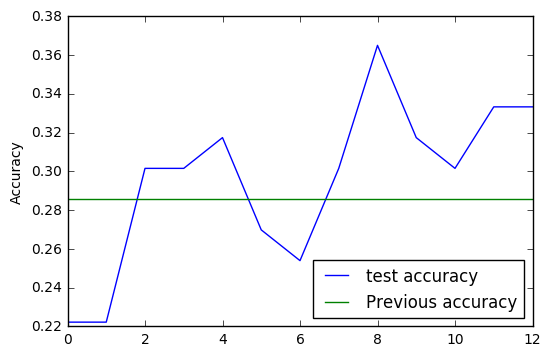

In [158]:
y = data['V_Grades']
accuracy_log = []
for i in range(len(criteria_list)):
    # using less features
    X=data[criteria_list[:i+1]].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    log_reg = LogisticRegression()
    log_reg.fit(X_train,y_train)
    prediction = log_reg.predict(X_test)
    accuracy_log.append(accuracy_score(y_test,prediction))
ax = plt.subplot()
fig = plt.plot(range(len(criteria_list)),accuracy_log,label='test accuracy')
plt.plot(range(len(criteria_list)),np.ones(len(criteria_list))*0.2857142857142857,label='Previous accuracy')
ax.set_ylabel('Accuracy')
plt.legend(loc=4)
print(['{0}: {1}'.format(x,data.columns[5:][x]) for x in range(len(data.columns[5:]))])

Max Distance appears to be a good predictor, but mean distance and std distance are poor predictors. Mean Angle and Hold type 0 could add insight.

In [141]:
y = data['V_Grades']
# using less features
X=data[['red','green','blue','total_holds','Max_dist','Mean_angle','hold_type_0']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
prediction = log_reg.predict(X_test)
print('Accuracy score: {0}'.format(accuracy_score(y_test,prediction)))

Accuracy score: 0.3968253968253968


Using a select few of the data points the model has been made more accurate.

What if grading is non-linear? Will attempt to identify if there is an increase in accuracy by squaring each variable separately.

['0: red', '1: green', '2: blue', '3: total_holds', '4: Max_dist', '5: Mean_angle', '6: hold_type_0']


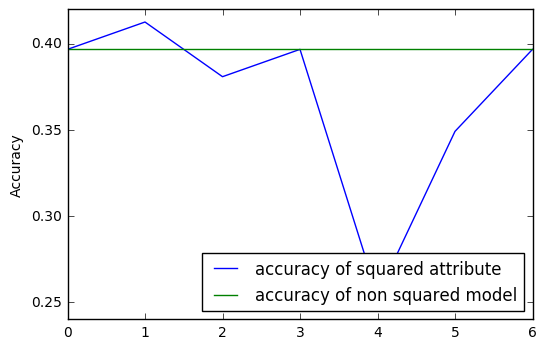

In [150]:
accuracy_log = []
best_attributes = ['red','green','blue','total_holds','Max_dist','Mean_angle','hold_type_0']
y = data['V_Grades']
# using less features
for i in range(len(best_attributes)):
    X=data[best_attributes].copy()
    X['attrib_sqr']=np.power(X[best_attributes[i]],2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    log_reg = LogisticRegression()
    log_reg.fit(X_train,y_train)
    prediction = log_reg.predict(X_test)
    accuracy_log.append(accuracy_score(y_test,prediction))
ax = plt.subplot()
fig = plt.plot(range(len(best_attributes)),accuracy_log,label='accuracy of squared attribute')
plt.plot(range(len(best_attributes)),np.ones(len(best_attributes))*0.3968253968253968,label='accuracy of non squared model')
ax.set_ylabel('Accuracy')
ax.legend(loc=4)
print(['{0}: {1}'.format(x,best_attributes[x]) for x in range(len(best_attributes))])

Model shows a slight increase in accuracy when the green criteria is squared.

If we apply this insight to the previous modelled data can we see an increase in accuracy? Original model accuracy was 41%.

In [153]:
data = pd.read_excel('formatted_climbing_data.xlsx')
data.columns

Index(['Image_Name', 'Climb', 'Grade', 'Setter', 'V_Grades', 'red', 'green',
       'blue', 'total_holds', 'Max_dist', 'Mean_dist', 'Std_dist',
       'Mean_angle', 'hold_type_0', 'hold_type_1', 'hold_type_2',
       'hold_type_3', 'hold_type_4'],
      dtype='object')

In [155]:
y = data['V_Grades']
X=data[best_attributes].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
prediction = log_reg.predict(X_test)
print('Accuracy score with best attributes: {0}'.format(accuracy_score(y_test,prediction)))

y = data['V_Grades']
X=data[best_attributes].copy()
X['green_sqr']=np.power(X['green'],2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
prediction = log_reg.predict(X_test)
print('Accuracy score with best attributes & green squared: {0}'.format(accuracy_score(y_test,prediction)))


Accuracy score with best attributes: 0.4014084507042254
Accuracy score with best attributes & green squared: 0.3873239436619718


This actually delivers a less accurate model than previously.